In [1]:
# Initialising required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime

In [2]:
# Loading the dataset
data = pd.read_csv("PCDA_UNCLEANED/interest_rate_uk.csv")
data

,DATE,INTGSBGBM193N
0,1/1/1989,9.9600
1,2/1/1989,9.7200
2,3/1/1989,9.8800
3,4/1/1989,10.1800
4,5/1/1989,10.1700
...,...,...
399,4/1/2022,1.8362
400,5/1/2022,1.9069
401,6/1/2022,2.3824
402,7/1/2022,2.1454


In [3]:
df_Interest = pd.read_csv("PCDA_UNCLEANED/interest_rate_uk.csv", parse_dates =["DATE"],index_col ="DATE")
df_Interest = df_Interest.INTGSBGBM193N.resample('Q').mean()
type(df_Interest)
df_Interest = df_Interest.to_frame()
df_Interest.reset_index(inplace=True)
df_Interest.columns = ['DATE','Interest_rate']
df_Interest

,DATE,Interest_rate
0,1989-03-31,9.853333
1,1989-06-30,10.300000
2,1989-09-30,10.090000
3,1989-12-31,10.520000
4,1990-03-31,11.546667
...,...,...
130,2021-09-30,0.714733
131,2021-12-31,0.953300
132,2022-03-31,1.413300
133,2022-06-30,2.041833


In [4]:
#data['DATE'] = pd.to_datetime(data['DATE'])

# Expolaratory Data Analysis

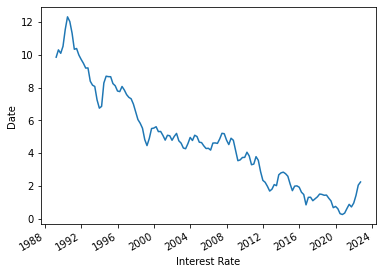

In [5]:
plt.plot(df_Interest['DATE'], df_Interest['Interest_rate'])
plt.xticks(rotation=30, ha='right')
plt.xlabel("Interest Rate")
plt.ylabel("Date")
plt.rcParams['figure.figsize']=(12.8,7.2)

## The time series plot exhibits negative trend component. There is no clear sign of seasonal component in the data. This can be confirmed after analysing ACF plot

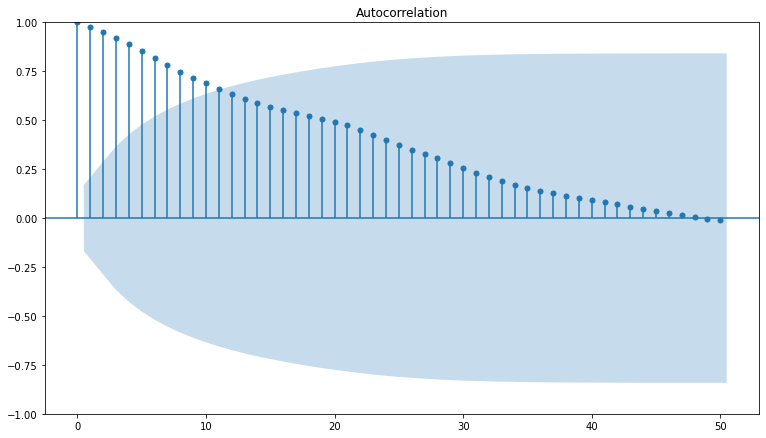

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
acf_plot = plot_acf(df_Interest['Interest_rate'],lags=50)

### According to the ACF plot, the autocorrelations are not declining quickly toward zero which indicates a trend component. As this is quarterly data and there are no significant spikes at every 4th lag, there is no seasonal component

### Due the pressence of Trend component, we can fit the data with below models
    1. Holt's linear Exponential 
    2. Damped trend Exponential
    3. Simple Linear Regression
    4. ARIMA

In [7]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn import metrics

# Split the data in to test and Train

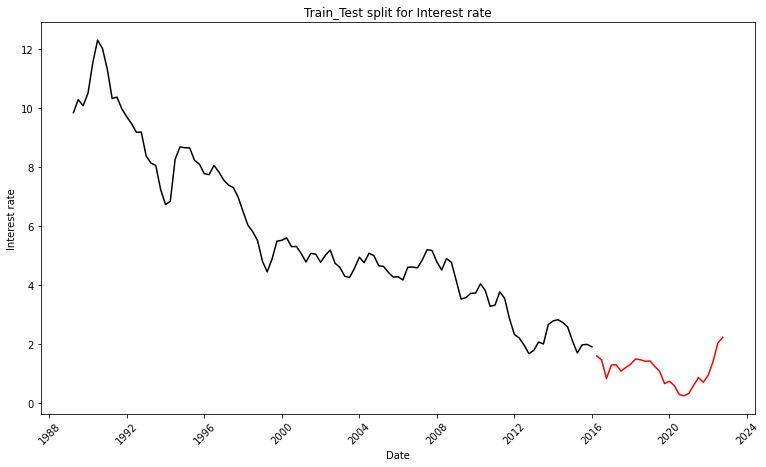

In [8]:
x1 = df_Interest.loc[:, df_Interest.columns == 'DATE'].to_numpy()
y1 = df_Interest.loc[:, df_Interest.columns == 'Interest_rate'].to_numpy()
x1_train, x1_test,y1_train, y1_test = train_test_split(x1, y1, test_size=0.20, shuffle=False)
x1_train
plt.plot(x1_train, y1_train, color = "black")
plt.plot(x1_test, y1_test, color = "red")
plt.ylabel('Interest rate')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train_Test split for Interest rate")
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

## Holt's linear Exponential model

In [9]:
def holt(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = Holt(y1_train).fit()
    fcast1 = fit1.forecast(period)
    mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
    mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print('The MAPE for Model fit is',MAPE_fit)
    print('The MAPE for Model Acc is ',MAPE_acc)
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    ax = plt.gca()
    print(fit1.summary())
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Holt's fit","Holt's Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Holt’s Linear Smoothing")
    plt.show()

The MAPE for Model fit is 0.058460639033462054
The MAPE for Model Acc is  0.436110240042287
                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                  108
Model:                           Holt   SSE                             15.338
Optimized:                       True   AIC                           -202.797
Trend:                       Additive   BIC                           -192.069
Seasonal:                        None   AICC                          -201.966
Seasonal Periods:                None   Date:                 Mon, 12 Dec 2022
Box-Cox:                        False   Time:                         18:03:28
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000   

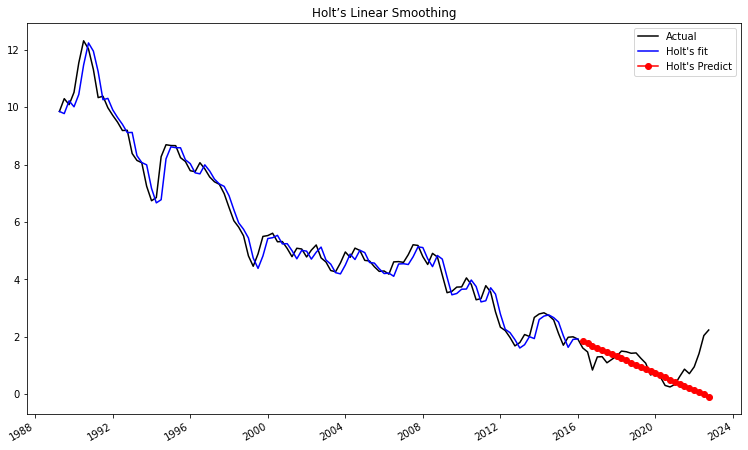

In [10]:
holt(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

### The level smoothing parameter is "1.00" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.00" indicates that the slope of the time series is hardly changing.
### The MAPE for Model Acc is "0.4361", which indicate model peformance is good.

# Damped trend Exponential

In [20]:
def damped(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = ExponentialSmoothing(y1_train,trend='add',seasonal=None, damped_trend=True).fit()
    fcast1 = fit1.forecast(period)
    mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
    mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print("The MAPE for Model fit is {}",MAPE_fit)
    print("The MAPE for Model Acc is {}",MAPE_acc)
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    print(fit1.summary())
    ax = plt.gca()
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Damped fit","Damped Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Damped Exponential Smoothing")
    plt.show()

The MAPE for Model fit is {} 0.0602042970206957
The MAPE for Model Acc is {} 1.1955999276722635
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                             15.153
Optimized:                         True   AIC                           -202.106
Trend:                         Additive   BIC                           -188.695
Seasonal:                          None   AICC                          -200.986
Seasonal Periods:                  None   Date:                 Sun, 11 Dec 2022
Box-Cox:                          False   Time:                         18:54:10
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level  

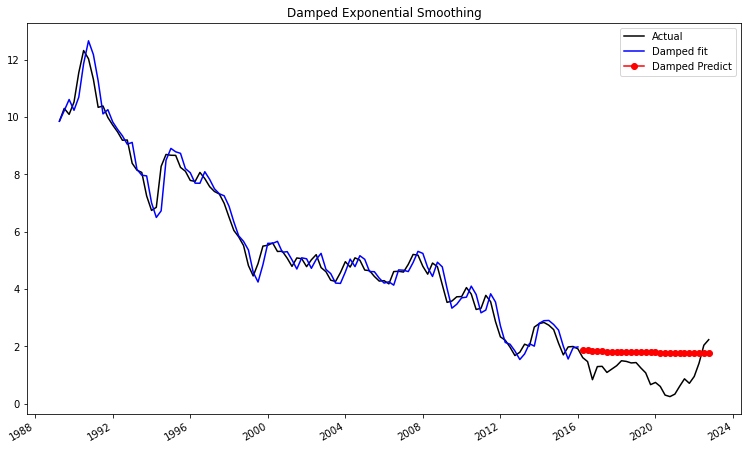

In [21]:
damped(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

### The level smoothing parameter is "1.00" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.25" indicates that the slope of the time series is very less changing.
### The damping smoothing parameter is "0.800" which indicates that more damping is applied.
### The MAPE for Model Acc is "1.195", which indicate model peformance is not good, and there are chances of overfitting.

# Simple Linear Regression

In [22]:
# Importing Linear Regression model from scikit learn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [23]:
df_Interest['DateIndex'] = np.arange(len(df_Interest.index))

In [24]:
X = df_Interest.loc[:, df_Interest.columns == 'DateIndex']
y = df_Interest.loc[:, df_Interest.columns == 'Interest_rate']

X = np.array(X).reshape((-1, 1))
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle=False)
X_test
X_test = np.array(X_test).reshape((-1, 1))

In [25]:
# fit the regression model
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Interest_rate   R-squared (uncentered):                   0.341
Model:                            OLS   Adj. R-squared (uncentered):              0.335
Method:                 Least Squares   F-statistic:                              55.46
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                    2.57e-11
Time:                        18:55:58   Log-Likelihood:                         -328.43
No. Observations:                 108   AIC:                                      658.9
Df Residuals:                     107   BIC:                                      661.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0589      0.008      7.447      0.000       0.043       0.075
==============================================================================
Omnibus:                        9.990   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.300
Skew:                           0.344   Prob(JB):                       0.0706
Kurtosis:                       2.160   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
y_pred = model.predict(X_test)
y_pred

array([6.35803984, 6.41691058, 6.47578132, 6.53465206, 6.5935228 ,
       6.65239354, 6.71126428, 6.77013502, 6.82900576, 6.8878765 ,
       6.94674724, 7.00561798, 7.06448872, 7.12335945, 7.18223019,
       7.24110093, 7.29997167, 7.35884241, 7.41771315, 7.47658389,
       7.53545463, 7.59432537, 7.65319611, 7.71206685, 7.77093759,
       7.82980833, 7.88867907])

In [27]:
MAPE_train=metrics.mean_absolute_percentage_error(y_train, model.fittedvalues)
print("The MAPE for Model fit is",MAPE_train)
MAPE_test=metrics.mean_absolute_percentage_error(y_test, y_pred)
print("The MAPE for Model Acc is",MAPE_test)

The MAPE for Model fit is 0.7254984002909372
The MAPE for Model Acc is 7.709321694779411


In [29]:
y_train = np.array(y_train).reshape((-1, 1))
model.fittedvalues = np.array(model.fittedvalues).reshape((-1, 1))

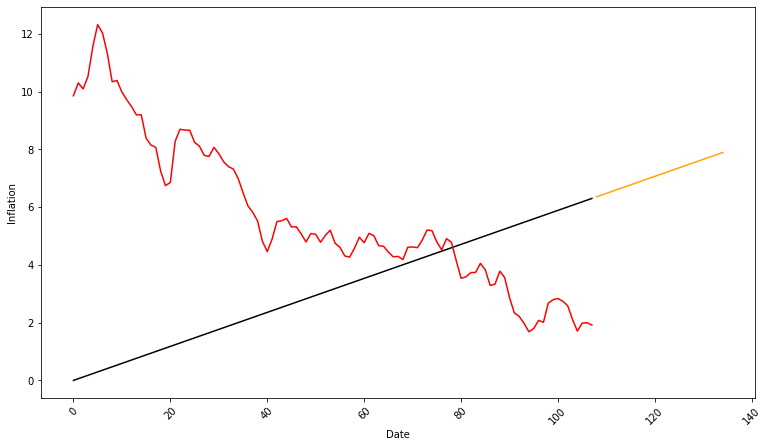

In [32]:
plt.plot(X_train,model.fittedvalues, color = "black")
plt.plot(X_train,y_train, color = "red")
plt.plot(X_test,y_pred, color = "Orange")
plt.ylabel('Inflation')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

# Model Assumptions
## 1.	First, we assume that the relationship between the forecast variable and the predictor variable is linear
### The relationship between the forecast variable “Interest_rate” and the predictor variable is linear.
## 2.Second, we make the following assumptions about the errors:     
        * Residuals are normally distributed
        * Residuals have constant variance 
        * Residual terms are independent

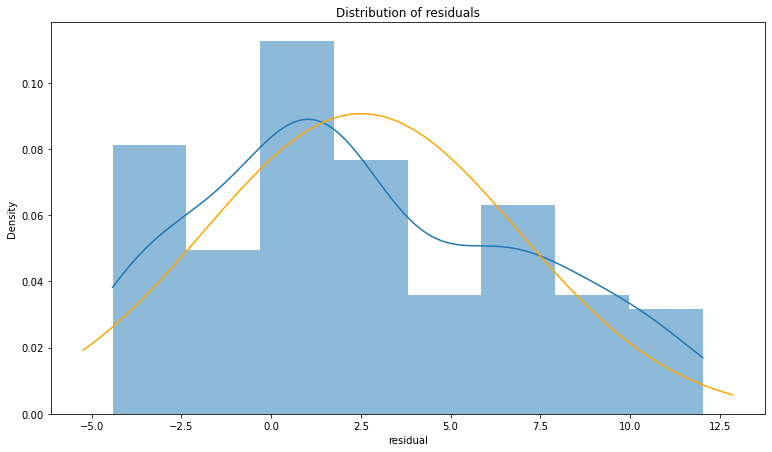

In [37]:
from scipy import stats
mu, std = stats.norm.fit(model.resid)
mu, std
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

## According to the histogram, the residuals appear not normally distributed, The assumption is not true

[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Predicted Values')]

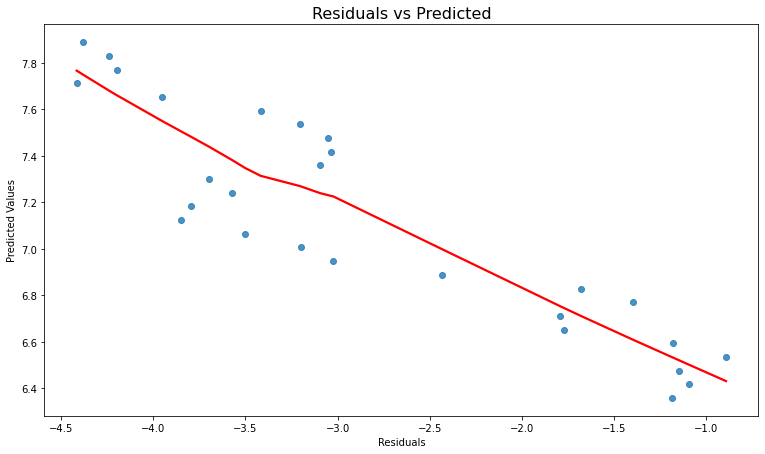

In [38]:
pred_resid = model.resid.tail(len(y_pred))

#Residual Vs Predicted Plot
fig, ax = plt.subplots(1,1)

sns.regplot(x=pred_resid, y=y_pred, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs Predicted', fontsize=16)
ax.set(xlabel='Residuals', ylabel='Predicted Values')

## The residual vs. predicted value scatterplot shows a pattern that indicates that the equal variances assumption is not correct.

In [40]:
#perform Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model.resid)

0.00622313380543

## As the Durbin-Watson statistic ranges from 0-4. The DW statistic close to zero indicate that there is positive serial correlation

# Model Evaluation
## 1.	Is the model logical? 
### The model is logical because the slope is positive which makes sense. With the increase in time there is increase in Interest_rate
## 2.	Is the slope term statistically significant? 
### The p-value for the slope term is less than alpha, so independent variable is a significant predictor
## 3.	What percent of the variation in the dependent variable is explained by variation in the independent variable 
### R2 = 34% so 34% of the variation in the dependent variable is explained by the independent variable

## ARIMA 

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split

In [20]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: statsmodels>=0.13.2 in c:\users\students\anaconda3\lib\site-packages (from pmdarima) (0.13.2)



In [21]:
df_Interest.head()

,DATE,Interest_rate
0,1989-03-31,9.853333
1,1989-06-30,10.300000
2,1989-09-30,10.090000
3,1989-12-31,10.520000
4,1990-03-31,11.546667


### Check if the data is stationary using Dickey-Fuller test 

In [22]:
ad_fuller_result = adfuller(df_Interest['Interest_rate'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5732277523309464
p-value: 0.4970266067564945


### The p value is higher than alpha so we cannot reject null hypothesis and must assume the data is not stationary

### Differencing can be done to make the data stationary 

In [23]:
df_Interest['Interest_rate_diff'] = df_Interest['Interest_rate'] - df_Interest['Interest_rate'].shift(1)

In [24]:
df_Interest['Interest_rate_diff'].head()

0         NaN
1    0.446667
2   -0.210000
3    0.430000
4    1.026667
Name: Interest_rate_diff, dtype: float64

In [25]:
df_Interest = df_Interest.dropna()
df_Interest

,DATE,Interest_rate,Interest_rate_diff
1,1989-06-30,10.300000,0.446667
2,1989-09-30,10.090000,-0.210000
3,1989-12-31,10.520000,0.430000
4,1990-03-31,11.546667,1.026667
5,1990-06-30,12.316667,0.770000
...,...,...,...
130,2021-09-30,0.714733,-0.156000
131,2021-12-31,0.953300,0.238567
132,2022-03-31,1.413300,0.460000
133,2022-06-30,2.041833,0.628533


### Check again if the differenced data is stationary 

In [26]:
ad_fuller_result = adfuller(df_Interest['Interest_rate_diff'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.847594506264816
p-value: 5.713887944705784e-12


### The p value is lower than alpha so we can assume that the data is stationary 

<AxesSubplot:>

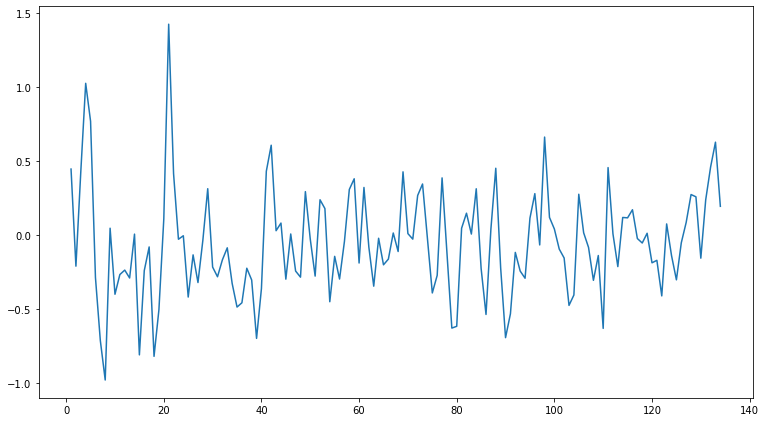

In [27]:
#viewing the stationary data 
df_Interest['Interest_rate_diff'].plot()

### Plotting ACF and PACF of differenced data to find which ARIMA model to choose 

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


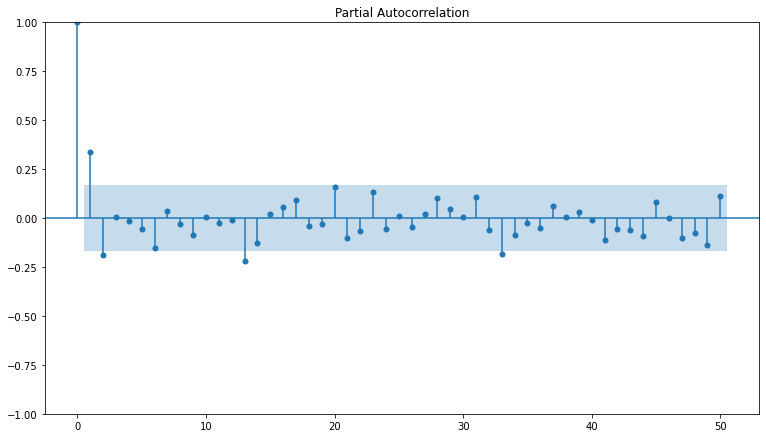

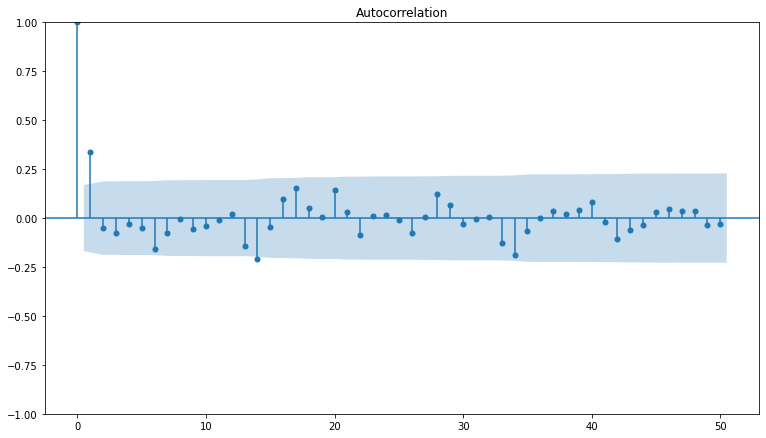

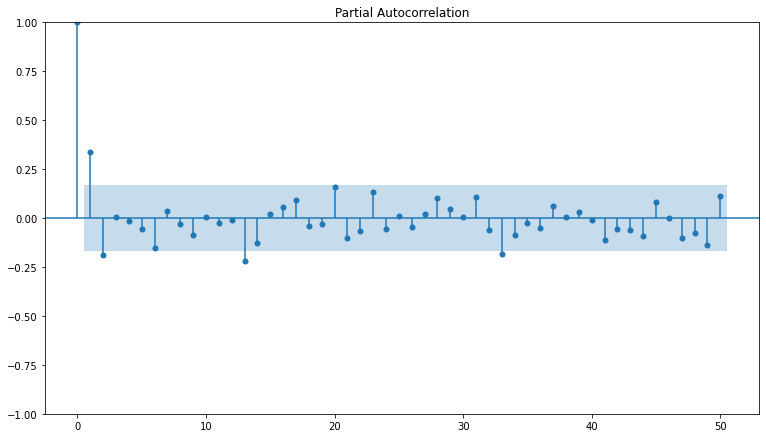

In [28]:
plot_acf(df_Interest['Interest_rate_diff'],lags=50)
plot_pacf(df_Interest['Interest_rate_diff'],lags=50)

### The arima model can be split up into AR(p), I(d) and MA(q). In the PACF graph, we can see two significant lags within the first 5 lags, making the AR equal to 2. In the ACF graph, we also see one significant lag, making the MA equal to 1. The I or differencing term in the arima model is equal to 1 since we did one level of differencing to make the data stationary. This makes our model ARIMA(2,1,1). Next, we build the model based on these specifications.

In [29]:
train = df_Interest.loc[:106]
test = df_Interest.loc[107:]

In [30]:
train

,DATE,Interest_rate,Interest_rate_diff
1,1989-06-30,10.300000,0.446667
2,1989-09-30,10.090000,-0.210000
3,1989-12-31,10.520000,0.430000
4,1990-03-31,11.546667,1.026667
5,1990-06-30,12.316667,0.770000
...,...,...,...
102,2014-09-30,2.586967,-0.154633
103,2014-12-31,2.111633,-0.475333
104,2015-03-31,1.706533,-0.405100
105,2015-06-30,1.982967,0.276433


In [31]:
test

,DATE,Interest_rate,Interest_rate_diff
107,2015-12-31,1.915767,-0.083100
108,2016-03-31,1.609967,-0.305800
109,2016-06-30,1.471967,-0.138000
110,2016-09-30,0.841100,-0.630867
111,2016-12-31,1.297800,0.456700
112,2017-03-31,1.306700,0.008900
113,2017-06-30,1.093667,-0.213033
114,2017-09-30,1.213000,0.119333
115,2017-12-31,1.329867,0.116867
116,2018-03-31,1.501500,0.171633


In [32]:
model = ARIMA(train['Interest_rate'], order = (2, 1, 1))
results = model.fit()

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
prediction = results.predict(start=106, end=133, dynamic=False)
prediction.columns = ["predicted_values"]
test["predicted_values"] = prediction

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Students\AppData\Local\Temp\ipykernel_12672\2371923517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_values"] = prediction


In [34]:
test

,DATE,Interest_rate,Interest_rate_diff,predicted_values
107,2015-12-31,1.915767,-0.083100,1.896438
108,2016-03-31,1.609967,-0.305800,1.900697
109,2016-06-30,1.471967,-0.138000,1.907689
110,2016-09-30,0.841100,-0.630867,1.909295
111,2016-12-31,1.297800,0.456700,1.908506
112,2017-03-31,1.306700,0.008900,1.907924
113,2017-06-30,1.093667,-0.213033,1.907873
114,2017-09-30,1.213000,0.119333,1.907968
115,2017-12-31,1.329867,0.116867,1.908011
116,2018-03-31,1.501500,0.171633,1.908007


In [35]:
test = test.dropna()
test

,DATE,Interest_rate,Interest_rate_diff,predicted_values
107,2015-12-31,1.915767,-0.083100,1.896438
108,2016-03-31,1.609967,-0.305800,1.900697
109,2016-06-30,1.471967,-0.138000,1.907689
110,2016-09-30,0.841100,-0.630867,1.909295
111,2016-12-31,1.297800,0.456700,1.908506
112,2017-03-31,1.306700,0.008900,1.907924
113,2017-06-30,1.093667,-0.213033,1.907873
114,2017-09-30,1.213000,0.119333,1.907968
115,2017-12-31,1.329867,0.116867,1.908011
116,2018-03-31,1.501500,0.171633,1.908007


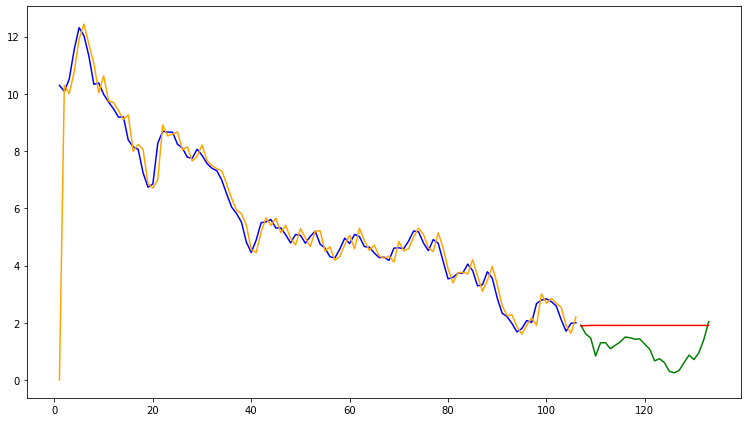

In [36]:
plt.plot(train['Interest_rate'], color = 'Blue', label = "Train")
plt.plot(test['Interest_rate'], color = 'Green', label = "Test")
plt.plot(test['predicted_values'], color ='Red', label = "Prediction")
plt.plot(results.fittedvalues, color='Orange')

In [37]:
MAPE_test=metrics.mean_squared_error(test['Interest_rate'], test['predicted_values'])
MAPE_train=metrics.mean_absolute_percentage_error(train['Interest_rate'], results.fittedvalues)
print("The MAPE for Model Accuracy(test) is",MAPE_test)
print("The MAPE for Model fit(train) is",MAPE_train)

The MAPE for Model Accuracy(test) is 0.8622008219882467
The MAPE for Model fit(train) is 0.06833759876304248


### The predicted values are not able to identify the curves in the graph and are graphed as more of a straight line. The MAPE for model fit is low showing that it is able to fit to the train data well. Model accuracy is high which is not good, meaning that the model is not able to fit the test data well. 

## Among the Holt's, Damped, simple regression, and ARIMA, Holt's model performed better. So we now forecast the Interest rate for next two quarter using Holt's Linear Trend model.

# Model Predictions for next two quarters 

In [65]:
fit_holt = ExponentialSmoothing(df_Interest['Interest_rate'],trend='add',seasonal=None).fit()
fcast_holt = fit_holt.forecast(2)

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [66]:
fcast_holt =  fcast_holt.to_frame()
fcast_holt.columns = ['Interest_rate']
fcast_holt

,Interest_rate
134,2.175977
135,2.115355
